# How to stream LLM tokens from your graph

In this example, we will stream tokens from the language model powering an
agent. We will use a ReAct agent as an example.

<div class="admonition info">
    <p class="admonition-title">Note</p>
    <p>
      If you are using a version of <code>@langchain/core</code> < 0.2.3, when calling chat models or LLMs you need to call <code>await model.stream()</code> within your nodes to get token-by-token streaming events, and aggregate final outputs if needed to update the graph state. In later versions of <code>@langchain/core</code>, this occurs automatically, and you can call <code>await model.invoke()</code>.
      <br>
      For more on how to upgrade <code>@langchain/core</code>, check out <a href="https://js.langchain.com/docs/how_to/installation/#installing-integration-packages">the instructions here</a>.
    </p>
</div>

This how-to guide closely follows the others in this directory, showing how to
incorporate the functionality into a prototypical agent in LangGraph.

<div class="admonition info">
    <p class="admonition-title">Streaming Support</p>
    <p>
        Token streaming is supported by many, but not all chat models. Check to see if your LLM integration supports token streaming <a href="https://js.langchain.com/docs/integrations/chat/">here (doc)</a>. Note that some integrations may support <i>general</i> token streaming but lack support for streaming tool calls.
    </p>
</div>

<div class="admonition tip">
    <p class="admonition-title">Note</p>
    <p>
        In this how-to, we will create our agent from scratch to be transparent (but verbose). You can accomplish similar functionality using the <code>createReactAgent({ llm, tools })</code> (<a href="/langgraphjs/reference/functions/langgraph_prebuilt.createReactAgent.html">API doc</a>) constructor. This may be more appropriate if you are used to LangChain's <a href="https://js.langchain.com/docs/how_to/agent_executor">AgentExecutor</a> class.
    </p>
</div>

## Setup

This guide will use OpenAI's GPT-4o model. We will optionally set our API key
for [LangSmith tracing](https://smith.langchain.com/), which will give us
best-in-class observability.

---

In [1]:
// process.env.OPENAI_API_KEY = "sk_...";

// Optional, add tracing in LangSmith
// process.env.LANGCHAIN_API_KEY = "ls__...";
// process.env.LANGCHAIN_CALLBACKS_BACKGROUND = "true";
// process.env.LANGCHAIN_TRACING = "true";
// process.env.LANGCHAIN_PROJECT = "Stream Tokens: LangGraphJS";

## Define the state

The state is the interface for all of the nodes in our graph.


In [2]:
import { Annotation } from "@langchain/langgraph";
import { BaseMessage } from "@langchain/core/messages";

const StateAnnotation = Annotation.Root({
  messages: Annotation<BaseMessage[]>({
    reducer: (x, y) => x.concat(y),
  }),
});

## Set up the tools

First define the tools you want to use. For this simple example, we'll create a placeholder search engine, but see the documentation [here](https://js.langchain.com/docs/how_to/custom_tools) on how to create your own custom tools.

In [3]:
import { tool } from "@langchain/core/tools";
import { z } from "zod";

const searchTool = tool((_) => {
  // This is a placeholder for the actual implementation
  return "Cold, with a low of 3℃";
}, {
  name: "search",
  description:
    "Use to surf the web, fetch current information, check the weather, and retrieve other information.",
  schema: z.object({
    query: z.string().describe("The query to use in your search."),
  }),
});

await searchTool.invoke({ query: "What's the weather like?" });

const tools = [searchTool];

We can now wrap these tools in a prebuilt
[ToolNode](/langgraphjs/reference/classes/langgraph_prebuilt.ToolNode.html).
This object will actually run the tools (functions) whenever they are invoked by
our LLM.

In [4]:
import { ToolNode } from "@langchain/langgraph/prebuilt";

const toolNode = new ToolNode(tools);

## Set up the model

Now load the [chat model](https://js.langchain.com/docs/concepts/#chat-models).

1. It should work with messages. We will represent all agent state in the form
   of messages, so it needs to be able to work well with them.
2. It should work with
   [tool calling](https://js.langchain.com/docs/how_to/tool_calling/#passing-tools-to-llms),
   meaning it can return function arguments in its response.

<div class="admonition tip">
    <p class="admonition-title">Note</p>
    <p>
        These model requirements are not general requirements for using LangGraph - they are just requirements for this one example.
    </p>
</div>

In [5]:
import { ChatOpenAI } from "@langchain/openai";

const model = new ChatOpenAI({
  model: "gpt-4o-mini",
  temperature: 0,
  streaming: true
});

After you've done this, we should make sure the model knows that it has these
tools available to call. We can do this by calling
[bindTools](https://v01.api.js.langchain.com/classes/langchain_core_language_models_chat_models.BaseChatModel.html#bindTools).

In [7]:
const boundModel = model.bindTools(tools);

## Define the graph

We can now put it all together.

In [8]:
import { StateGraph, END } from "@langchain/langgraph";
import { AIMessage } from "@langchain/core/messages";

const routeMessage = (state: typeof StateAnnotation.State) => {
  const { messages } = state;
  const lastMessage = messages[messages.length - 1] as AIMessage;
  // If no tools are called, we can finish (respond to the user)
  if (!lastMessage?.tool_calls?.length) {
    return END;
  }
  // Otherwise if there is, we continue and call the tools
  return "tools";
};

const callModel = async (
  state: typeof StateAnnotation.State,
) => {
  // For versions of @langchain/core < 0.2.3, you must call `.stream()`
  // and aggregate the message from chunks instead of calling `.invoke()`.
  const { messages } = state;
  const responseMessage = await boundModel.invoke(messages);
  return { messages: [responseMessage] };
};

const workflow = new StateGraph(StateAnnotation)
  .addNode("agent", callModel)
  .addNode("tools", toolNode)
  .addEdge("__start__", "agent")
  .addConditionalEdges("agent", routeMessage)
  .addEdge("tools", "agent");

const agent = workflow.compile();

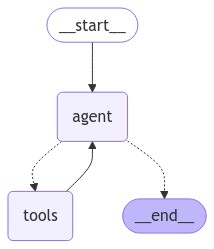

In [9]:
import * as tslab from "tslab";

const runnableGraph = agent.getGraph();
const image = await runnableGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

## Streaming LLM Tokens

You can access the LLM tokens as they are produced by each node with two methods:

- The `stream` method along with `streamMode: "messages"`
- The `streamEvents` method

### The stream method

<div class="admonition tip">
    <p class="admonition-title">Compatibility</p>
    <p>
        This section requires <code>@langchain/langgraph>=0.2.20</code>. For help upgrading, see <a href="/langgraphjs/how-tos/manage-ecosystem-dependencies/">this guide</a>.
    </p>
</div>

For this method, you must be using an LLM that supports streaming as well and enable it when constructing the LLM (e.g. `new ChatOpenAI({ model: "gpt-4o-mini", streaming: true })`) or call `.stream` on the internal LLM call.

In [15]:
import { isAIMessageChunk } from "@langchain/core/messages";

const stream = await agent.stream(
  { messages: [{ role: "user", content: "What's the current weather in Nepal?" }] },
  { streamMode: "messages" },
);

for await (const [message, _metadata] of stream) {
  if (isAIMessageChunk(message) && message.tool_call_chunks?.length) {
    console.log(`${message.getType()} MESSAGE TOOL CALL CHUNK: ${message.tool_call_chunks[0].args}`);
  } else {
    console.log(`${message.getType()} MESSAGE CONTENT: ${message.content}`);
  }
}

ai MESSAGE TOOL CALL CHUNK: 
ai MESSAGE TOOL CALL CHUNK: {"
ai MESSAGE TOOL CALL CHUNK: query
ai MESSAGE TOOL CALL CHUNK: ":"
ai MESSAGE TOOL CALL CHUNK: current
ai MESSAGE TOOL CALL CHUNK:  weather
ai MESSAGE TOOL CALL CHUNK:  in
ai MESSAGE TOOL CALL CHUNK:  Nepal
ai MESSAGE TOOL CALL CHUNK: "}
ai MESSAGE CONTENT: 
tool MESSAGE CONTENT: Cold, with a low of 3℃
ai MESSAGE CONTENT: 
ai MESSAGE CONTENT: The
ai MESSAGE CONTENT:  current
ai MESSAGE CONTENT:  weather
ai MESSAGE CONTENT:  in
ai MESSAGE CONTENT:  Nepal
ai MESSAGE CONTENT:  is
ai MESSAGE CONTENT:  cold
ai MESSAGE CONTENT: ,
ai MESSAGE CONTENT:  with
ai MESSAGE CONTENT:  a
ai MESSAGE CONTENT:  low
ai MESSAGE CONTENT:  temperature
ai MESSAGE CONTENT:  of
ai MESSAGE CONTENT:  
ai MESSAGE CONTENT: 3
ai MESSAGE CONTENT: ℃
ai MESSAGE CONTENT: .
ai MESSAGE CONTENT: 


### The streamEvents method

You can also use the `streamEvents` method like this:

In [17]:
const eventStream = await agent.streamEvents(
  { messages: [{ role: "user", content: "What's the weather like today?" }] },
  {
    version: "v2",
  }
);

for await (const { event, data } of eventStream) {
  if (event === "on_chat_model_stream" && isAIMessageChunk(data.chunk)) {
    if (data.chunk.tool_call_chunks !== undefined && data.chunk.tool_call_chunks.length > 0) {
      console.log(data.chunk.tool_call_chunks);
    }
  }
}

[
  {
    name: 'search',
    args: '',
    id: 'call_fNhlT6qSYWdJGPSYaVqLtTKO',
    index: 0,
    type: 'tool_call_chunk'
  }
]
[
  {
    name: undefined,
    args: '{"',
    id: undefined,
    index: 0,
    type: 'tool_call_chunk'
  }
]
[
  {
    name: undefined,
    args: 'query',
    id: undefined,
    index: 0,
    type: 'tool_call_chunk'
  }
]
[
  {
    name: undefined,
    args: '":"',
    id: undefined,
    index: 0,
    type: 'tool_call_chunk'
  }
]
[
  {
    name: undefined,
    args: 'current',
    id: undefined,
    index: 0,
    type: 'tool_call_chunk'
  }
]
[
  {
    name: undefined,
    args: ' weather',
    id: undefined,
    index: 0,
    type: 'tool_call_chunk'
  }
]
[
  {
    name: undefined,
    args: ' today',
    id: undefined,
    index: 0,
    type: 'tool_call_chunk'
  }
]
[
  {
    name: undefined,
    args: '"}',
    id: undefined,
    index: 0,
    type: 'tool_call_chunk'
  }
]
